# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# XGBoost
import xgboost as xgb

# Training and Evaluation Tools
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Importing the data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# eXtreme Gradient Boosting

## Mathematical Description

eXtreme Gradient Boosting, or XGBoost, is an algorithm based on Classifcation and Regression Trees, or CARTs.

A simple diagram demonstrates why they have this name:

<img src="Graphics\Tree.png" width="600" height="600" />

XGboost combines several of these CARTs to arrive at a prediction. Mathematically, this looks like:

$${\hat{y}}_i=\sum_{k=1}^{K}f_k({\bf{x}}_i)$$

So, the algorithm seeks to find the CARTs $f$ used to create our predictions, call this set $\Xi$, to minimize the cost function $J$ over the training set of size $m$:

$$J(\Xi)=\sum_{i=1}^{m}{\mathcal{L}}(y_i, {\hat{y}}_i)+\sum_{k=1}^{K}\Omega(f_k)$$

In the above, $\Xi$ is the set of possible CARTs, $\mathcal{L}$ is the loss function between the actual value $y$ and the prediction $\hat{y}$, and $\Omega$ is a regularization function on the CARTs themselves.

Understanding that we build each $\hat{y}$ iteratively by adding the various predictions of each CART $f$ at the $t^{th}$, expanding the above function to a second-order Taylor polynomial, and dropping everything constant, we arrive at:

$${\tilde{J}}(f_t)=\sum_{i=1}^{m}[g_if_t({\bf{x}}_i)+\dfrac{1}{2}h_i{f_t}^2({\bf{x}}_i)]+\Omega(f_t)$$

In the above, $g_i$ is the partial derivative of the loss function with respect to ${\hat{y}}_i^{(t-1)}$ and $h_i$ is the second partial derivative of the loss function with respect to ${\hat{y}}_i^{(t-1)}$.

Expanding our regularization function, we get:

$$\Omega(f_t)=\gamma T+\dfrac{1}{2}\lambda\sum_{j=1}^{T}w^2_j$$

Here, $T$ is the number of leaves of the $t^{th}$ CART $f$ and $w_j$ is the weight of the $j^{th}$ leaf. 

After signficant rearranging that can be found in the Primer for this project, we arrive at:

$${\tilde{J}}({\bf{w}},q)^{(t)}=\sum_{j=1}^{T}[G_j w_j + \dfrac{1}{2}(H_j+\lambda)w_j^2]+ \gamma T$$

In the above, $G_j$ and $H_j$ are the sums of the $g_i$ and $h_i$ respectively. The new parameters of the ${\tilde{J}}$ function are $\bf{w}$, the weights of the $t^{th}$ CART $f$ and $q$ is a the actual decision structure. 

Fixing a structure $q$, the optimal weights are:

$$w^*_j=-\dfrac{G_j}{H_j+\lambda}$$

Plugging this into the above equation, we have:

$${\tilde{J}}(q)^{(t)}=\dfrac{1}{2}\sum_{j=1}^{T} \dfrac{G_j^2}{H_j+\lambda}+\gamma T$$

This tells how good of a tree structure we have in $q$. 

To determine if a split is beneficial or not, we use the following:

$$Gain=\dfrac{1}{2}\left[\dfrac{G_L^2}{H_L+\lambda}+\dfrac{G_R^2}{H_R+\lambda}-\dfrac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right]-\gamma$$

In the above $L$ is the left split and $R$ is the right. If the $Gain$ is less than zero, that branch isn't beneficial to use and we can prune it.

Now that we have the mathematical underpinning, we can search through various trees and weights to find a proper set of CARTs that minimize the cost function $J$. The XGboost is a specific implementation of the described algorithm with specific computation tools meant to speed it up, and the curious reader is referred to the documentation for XGBoost found in the Bibliography to learn more about it.

## Training and testing data

In [3]:
# Defining a function to create PCA matrices

def PCA_creation_train_val_test(no_components, X_train, X_val, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_val and X_test 
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    # Transforming the X_val and X_test
    X_val=pca.transform(X_val)
    X_test=pca.transform(X_test)
    
    return X_train, X_val, X_test

In [4]:
# Train and test splitting and scaling

X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

num_classes=2 # Used for one-hot encoding, but we won't be doing that with 2 classes

# Split into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)
y_train=np.array(y_train)
y_val=np.array(y_val)

X_train, X_val, X_test=PCA_creation_train_val_test(20, X_train, X_val, X_test)

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


## Grid Search

In [14]:
# Setting up our grid

param_grid = {
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001, 0.00001],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 5, 10],
}

# Fitting our XGBoost with out grid

# Init classifier
xgb_cl = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, verbosity=0)

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=1, cv=5)

# Fit
grid_cv.fit(X_train, y_train)

# Getting the score and best parameters from our grid search

print('Score ',grid_cv.best_score_)
print('Params ', grid_cv.best_params_)

Score  0.5529019980970504
Params  {'gamma': 1, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 10}


In [9]:
# Training our XGBoost with our best params

# Setting up our XGBoost with our best params
best_xgb = xgb.XGBClassifier(gamma=1,
                             learning_rate= 0.01,
                             max_depth=5,
                             reg_lambda=10,
                            verbosity=0)

# Fitting the model
best_xgb.fit(X_train, y_train)

# The model
print(best_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

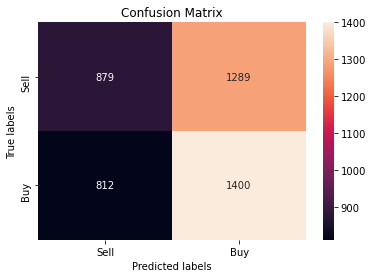

In [10]:
# Confusion Matrix

# Performance
y_pred=best_xgb.predict(X_test)

# Plotting Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sell', 'Buy']); ax.yaxis.set_ticklabels(['Sell', 'Buy']);

## Saving and Reloading the Model

In [8]:
# save to JSON
best_xgb.save_model("Models/XGB BTC.txt")

In [18]:
# Loading the model
model = xgb.XGBClassifier()
model.load_model("Models/XGB BTC.json")